In [575]:
import os 
import pandas as pd
import numpy as np
import xlrd

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from statsmodels.iolib.table import SimpleTable
import statsmodels.api as sm

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Загрузим данные

In [21]:
Data = pd.read_csv("2020_02_10_PrepData.csv", index_col=0)
Data.index = pd.to_datetime(Data.index)

In [24]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86398 entries, 2020-10-02 00:12:03.200000 to 2020-11-02 00:12:00.200000
Data columns (total 22 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Температура обмотки статора А (датчик №1)             86398 non-null  float64
 1   Температура обмотки статора А (датчик №2)             86398 non-null  float64
 2   Температура обмотки статора В (датчик №1)             86398 non-null  float64
 3   Температура обмотки статора В (датчик №2)             86398 non-null  float64
 4   Температура обмотки статора С (датчик №1)             86398 non-null  float64
 5   Температура обмотки статора С (датчик №2)             86398 non-null  float64
 6   Температура переднего подшипника двигателя            86398 non-null  float64
 7   Температура заднего подшипника двигателя              86398 non-null  float64
 8   Давлени

## Выберем изучаемый параметр

In [434]:
Selected_Sensor = "Вибрация переднего подшипника двигателя (осевая)"
Selected_Series = Data[Selected_Sensor].iloc[:40000]

# Проверка на стационарность

## Исходный ряд

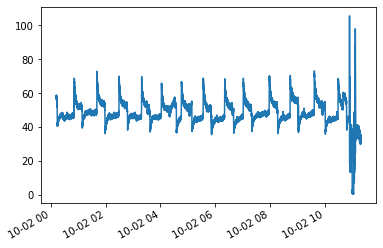

In [435]:
Selected_Series.plot()

### Гистограмма ряда

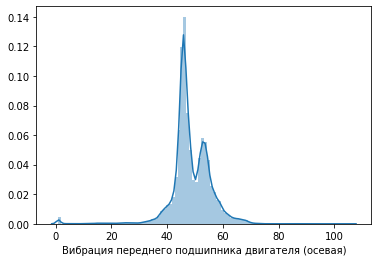

In [436]:
## Если гистограмма примерно нормального распределения, то ряд можно считать стационарным
sns.distplot(Selected_Series, bins=100)

### Тест Харки-Бера 
https://ru.wikipedia.org/wiki/Тест_Харке_—_Бера

In [437]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(Selected_Series)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB         p-value         skew             kurtosis     
-----------------------------------------------------------------
203820.42360478613     0.0 -1.3912763695657941 13.702787226550987
-----------------------------------------------------------------


__Гипотеза о нормальности распределения ряда отвергается__

P.S. Формально, из-за того что это периодический сигнал

### Тест Дикки-Фуллера
Для проверки стационарности 

In [438]:
test = sm.tsa.adfuller(Selected_Series)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -7.598696833083445
p-value:  2.4215264946962625e-11
Critical values:  {'1%': -3.4305137181193537, '5%': -2.861612359645033, '10%': -2.5668085147157766}
Единичных корней нет, ряд стационарен


## Дифференцированный ряд

In [115]:
Diff_Series = Selected_Series.diff(periods=1).dropna()

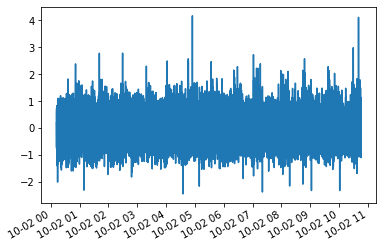

In [116]:
Diff_Series.plot()

### Гистограмма ряда

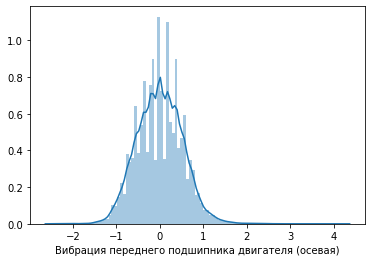

In [118]:
sns.distplot(Diff_Series, bins=100)

### Тест Харки-Бера 
https://ru.wikipedia.org/wiki/Тест_Харке_—_Бера

In [119]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(Diff_Series)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB               p-value                skew             kurtosis    
-----------------------------------------------------------------------------
751.0899434218828 7.996336826151817e-164 0.1642886989244749 3.605327988189955
-----------------------------------------------------------------------------


__Гипотеза о нормальности распределения ряда отвергается__

### Тест Дикки-Фуллера

In [120]:
test = sm.tsa.adfuller(Diff_Series)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -26.533453839982133
p-value:  0.0
Critical values:  {'1%': -3.4305223479360203, '5%': -2.86161617371486, '10%': -2.5668105448419607}
единичных корней нет, ряд стационарен


## Сезонное дифференцирование ряда

Определим сезонность по периоду завалки чугуна

In [164]:
season_inds = []
prev_val = 0
for i, val in enumerate(Data[" Плавка Завалка чугуна"].iloc[:38000]):
    if val == 0 and prev_val == 1:
        season_inds.append(Data.index[i-1])
    prev_val=val

И посчитаем среднюю разницу между временами спадающего фронта

In [174]:
from functools import reduce
print(np.mean(list(map(lambda x,y: y-x, season_inds, season_inds[1:]))))
list(map(lambda x,y: y-x, season_inds, season_inds[1:]))

0 days 00:44:27.230769


[Timedelta('0 days 00:49:34'),
 Timedelta('0 days 00:48:21'),
 Timedelta('0 days 00:49:26'),
 Timedelta('0 days 00:43:19'),
 Timedelta('0 days 00:43:58'),
 Timedelta('0 days 00:47:39'),
 Timedelta('0 days 00:47:00'),
 Timedelta('0 days 00:40:53'),
 Timedelta('0 days 00:56:48'),
 Timedelta('0 days 00:45:53'),
 Timedelta('0 days 00:44:51'),
 Timedelta('0 days 00:07:54'),
 Timedelta('0 days 00:52:18')]

In [204]:
Season_Diff_Series = Selected_Series.diff(periods=2950).dropna()

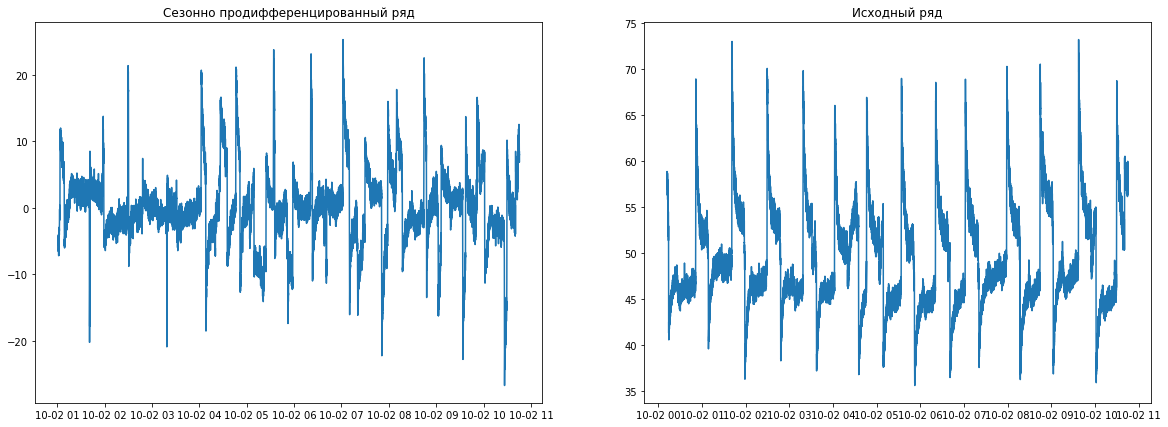

In [205]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(20,7))
ax1.set_title("Сезонно продифференцированный ряд")
ax1.plot(Season_Diff_Series)

ax2.set_title("Исходный ряд")
ax2.plot(Selected_Series)

### Гистограмма ряда

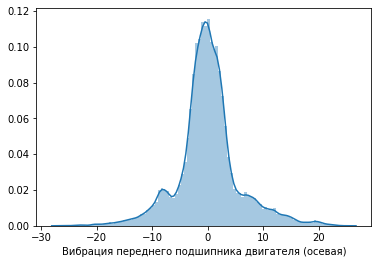

In [206]:
sns.distplot(Season_Diff_Series, bins=100)

__Видно что до конца избавится от сезонности не удалось, но стало лучше__

### Тест Харки-Бера

In [207]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(Season_Diff_Series)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB        p-value        skew             kurtosis    
--------------------------------------------------------------
7763.058910203584     0.0 0.2390533215640844 5.255451319023924
--------------------------------------------------------------


### Тест Дикки-Фуллера

In [208]:
test = sm.tsa.adfuller(Season_Diff_Series)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -9.766931033992218
p-value:  7.307550578203758e-17
Critical values:  {'1%': -3.4305368668659018, '5%': -2.861622590536746, '10%': -2.5668139603470017}
единичных корней нет, ряд стационарен


# Построение модели скользящего экспоненциального среднего

In [220]:
from scipy import stats

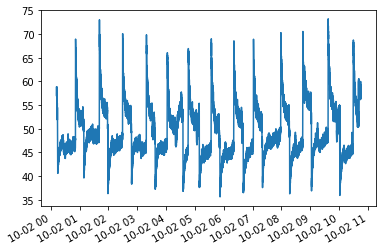

In [219]:
# Исходный ряд
Selected_Series.plot()

## Преобразование Бокса-Кокса

In [439]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

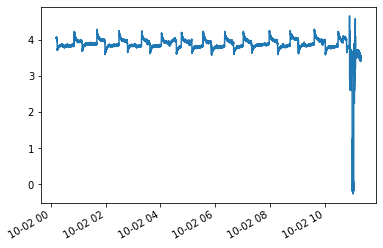

In [440]:
LAMBDA = 0

homosced_SS = stats.boxcox(Selected_Series, lmbda=LAMBDA)
homosced_SS = homosced_SS.reshape(homosced_SS.shape[0],)
homosced_SS = pd.Series(homosced_SS, index=Selected_Series.index)

homosced_SS.plot()

## Избавимся от тренда

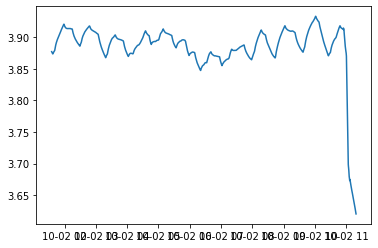

In [441]:
plt.plot(homosced_SS.rolling(window=5000).mean())

In [274]:
MA = homosced_SS.rolling(window=5000).mean()
detrend_SS = homosced_SS - MA

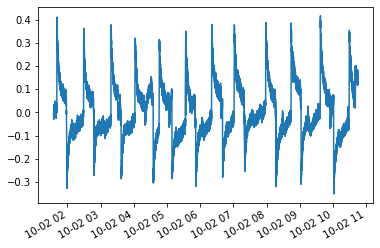

In [275]:
detrend_SS.plot()

In [276]:
from statsmodels.tsa.api import ExponentialSmoothing

In [283]:
detrend_SS.dropna()

2020-10-02 01:35:22.200    0.011552
2020-10-02 01:35:23.200    0.001987
2020-10-02 01:35:24.200   -0.026413
2020-10-02 01:35:25.200   -0.030769
2020-10-02 01:35:26.200   -0.023167
                             ...   
2020-10-02 10:45:18.200    0.118472
2020-10-02 10:45:19.200    0.118967
2020-10-02 10:45:20.200    0.125300
2020-10-02 10:45:21.200    0.123934
2020-10-02 10:45:22.200    0.125236
Length: 33001, dtype: float64

In [311]:
Train = homosced_SS.dropna().iloc[:25000]
Test = homosced_SS.dropna().iloc[25000:]

/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


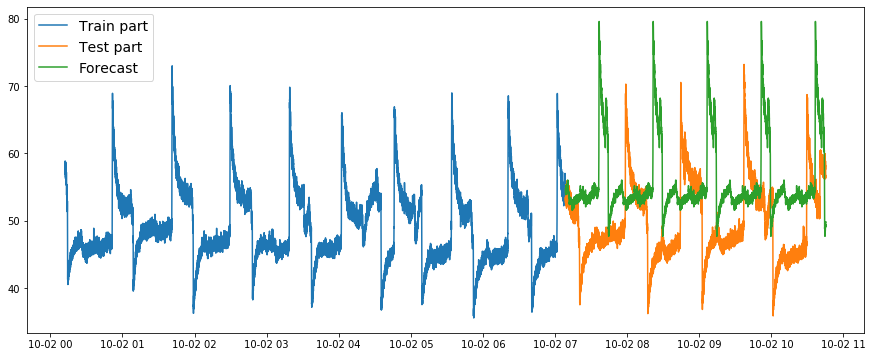

In [312]:
forecast = Test.copy()

fit1 = ExponentialSmoothing(np.asarray(Train), seasonal='add',seasonal_periods=2700).fit()
forecast = pd.Series(fit1.forecast(len(Test)))
forecast.index = Test.index

plt.figure(figsize=(15,6))
plt.plot(invboxcox(Train, lmbda=LAMBDA), label = 'Train part')
plt.plot(invboxcox(Test, lmbda=LAMBDA), label = 'Test part')
plt.plot(invboxcox(forecast, lmbda=LAMBDA), label = 'Forecast')

plt.legend(loc='upper left', fontsize=14)

# Построение модели ARIMA

## Выбор параметров $d, p, q$

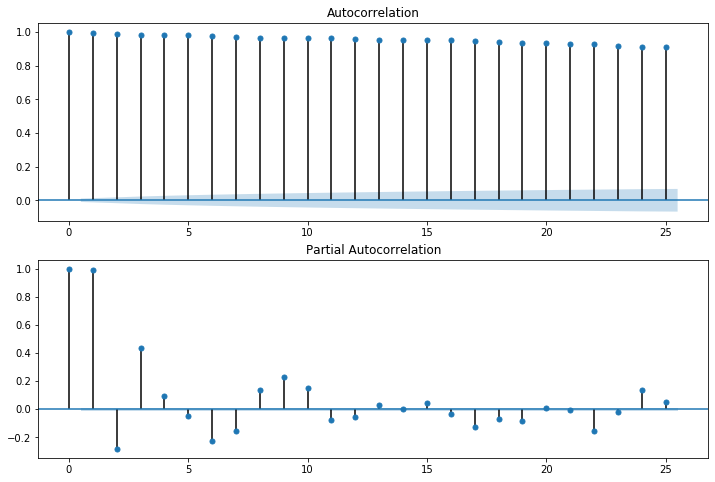

In [313]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Selected_Series.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Selected_Series, lags=25, ax=ax2)

In [368]:
src_data_model = np.log10(Selected_Series)
model = sm.tsa.ARIMA(src_data_model, order=(3,1,8)).fit(full_output=False, disp=0)

/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


In [369]:
print(model.summary())

                                             ARIMA Model Results                                              
Dep. Variable:     D.Вибрация переднего подшипника двигателя (осевая)   No. Observations:                37999
Model:                                                 ARIMA(3, 1, 8)   Log Likelihood              161089.666
Method:                                                       css-mle   S.D. of innovations              0.003
Date:                                                Tue, 07 Apr 2020   AIC                        -322153.332
Time:                                                        10:25:39   BIC                        -322042.243
Sample:                                                    10-02-2020   HQIC                       -322118.084
                                                         - 10-02-2020                                         
                                                               coef    std err          z      P>|z|      [0.025

In [370]:
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
q_test = sm.tsa.stattools.acf(model.resid, qstat=True)
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


         Q-stat        p-value
0      0.292691   5.885011e-01
1      0.908332   6.349774e-01
2      1.581651   6.635573e-01
3      3.678798   4.512171e-01
4      8.032941   1.544295e-01
5     18.542685   5.009895e-03
6    101.374155   5.611349e-19
7    102.443475   1.350729e-18
8    138.360082   2.248974e-25
9    144.382934   5.318264e-26
10   146.918232   6.346224e-26
11   350.232019   1.253251e-67
12   424.386000   1.566399e-82
13   506.302444   4.277046e-99
14   541.922787  7.502956e-106
15   699.335983  1.790762e-138
16   801.114072  2.637947e-159
17  1183.848925  3.228357e-240
18  1387.086037  7.515411e-283
19  1467.407970  3.905582e-299
20  1622.133965   0.000000e+00
21  1932.693448   0.000000e+00
22  2065.667293   0.000000e+00
23  2123.362115   0.000000e+00
24  2194.545482   0.000000e+00
25  2536.287278   0.000000e+00
26  2679.667194   0.000000e+00
27  2821.354880   0.000000e+00
28  2831.743594   0.000000e+00
29  2839.111390   0.000000e+00
30  2844.041696   0.000000e+00
31  2929

In [371]:
pred = model.predict('2020-10-02 10:28:43.200000', '2020-10-02 10:45:21.200000')
trn = Selected_Series.iloc[-999:]
r2 = r2_score(trn, pred)
print('R^2: {:.2f}'.format(r2))

R^2: -181.10


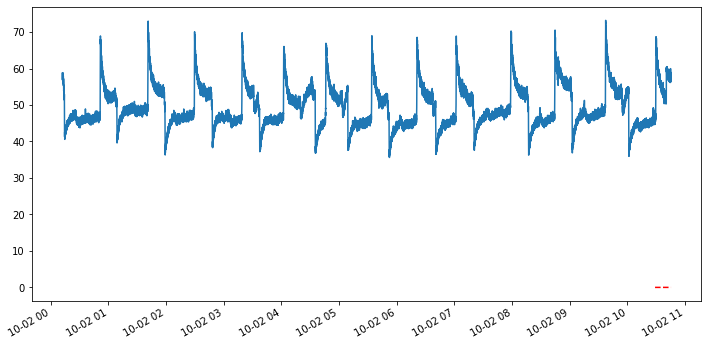

In [373]:
Selected_Series.plot(figsize=(12,6))
pred.plot(style='r--')

# Построение модели SARIMA

In [374]:
homosced_SS

2020-10-02 00:12:03.200    4.043028
2020-10-02 00:12:04.200    4.046640
2020-10-02 00:12:05.200    4.043632
2020-10-02 00:12:06.200    4.043788
2020-10-02 00:12:07.200    4.049858
                             ...   
2020-10-02 10:45:18.200    4.031156
2020-10-02 10:45:19.200    4.031685
2020-10-02 10:45:20.200    4.038055
2020-10-02 10:45:21.200    4.036726
2020-10-02 10:45:22.200    4.038067
Length: 38000, dtype: float64

In [378]:
train, test = homosced_SS[0:-8000], homosced_SS[-8000:]

my_order = (2, 0, 2)
my_seasonal_order = (0, 1, 0, 5)

In [381]:
history = [x for x in train]
predictions = list()
predict=list()

model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,
                           enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)

for t in range(len(test)):
    output = model_fit.forecast()
    predict.append(output[0])
#     yhat = 10**output[0]
    predictions.append(predict)
    obs = test[t]
    history.append(obs)
   # print('predicted=%f, expected=%f' % (output[0], obs))
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)
# plot


/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NameError: name 'pyplot' is not defined

<Figure size 864x504 with 0 Axes>

# LSTM

In [851]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from math import sqrt

from tqdm.notebook import tqdm

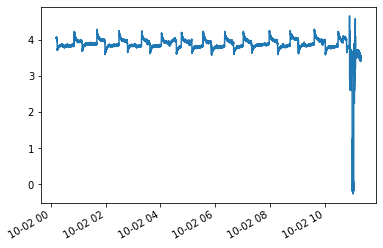

In [520]:
homosced_SS.plot()

In [703]:
def timeseries_to_supervised(data, X_lag=60, y_lag=12):
    df = pd.DataFrame(data)
    X_columns = [df.shift(i) for i in range(0, X_lag+1)]
    y_columns = [df.shift(-i) for i in range(1, y_lag+1)]
    #columns = X_columns + y_columns
    
    X = pd.concat(X_columns, axis=1).fillna(0).values
    y = pd.concat(y_columns, axis=1).fillna(0).values
    
    return X, y

In [969]:
X, y = timeseries_to_supervised(homosced_SS[::5], X_lag=36, y_lag=12)

In [975]:
n_steps = 36+1
n_features = 1
y_dim = 12

# define model
# model = Sequential()

# model.add(LSTM(15, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
# model.add(LSTM(10, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
# model.add(LSTM(5, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(y_dim))

# model.compile(optimizer='adam', loss='mse')


model = Sequential()

model.add(LSTM(
          units=10,
          return_sequences=False))


model.add(Dense(units=y_dim))
model.compile(loss='mae', optimizer='adam')

# model.summary()

In [976]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

Train_X, Test_X, Train_y, Test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

In [977]:
model.fit(Train_X, Train_y, epochs=20, verbose=1, validation_split=0.2)

Train on 5120 samples, validate on 1280 samples
Epoch 1/20
5120/5120 [==============================] - 9s 2ms/step - loss: 3.0359 - val_loss: 1.9670
Epoch 2/20
5120/5120 [==============================] - 3s 558us/step - loss: 0.9371 - val_loss: 0.2010
Epoch 3/20
5120/5120 [==============================] - 3s 570us/step - loss: 0.1029 - val_loss: 0.0894
Epoch 4/20
5120/5120 [==============================] - 3s 573us/step - loss: 0.0849 - val_loss: 0.0890
Epoch 5/20
5120/5120 [==============================] - 3s 577us/step - loss: 0.0846 - val_loss: 0.0896
Epoch 6/20
5120/5120 [==============================] - 3s 570us/step - loss: 0.0847 - val_loss: 0.0899
Epoch 7/20
 768/5120 [===>..........................] - ETA: 2s - loss: 0.0851

KeyboardInterrupt: 

In [978]:
# demonstrate prediction
yhat = model.predict(Test_X, verbose=1)

1600/1600 [==============================] - 5s 3ms/step


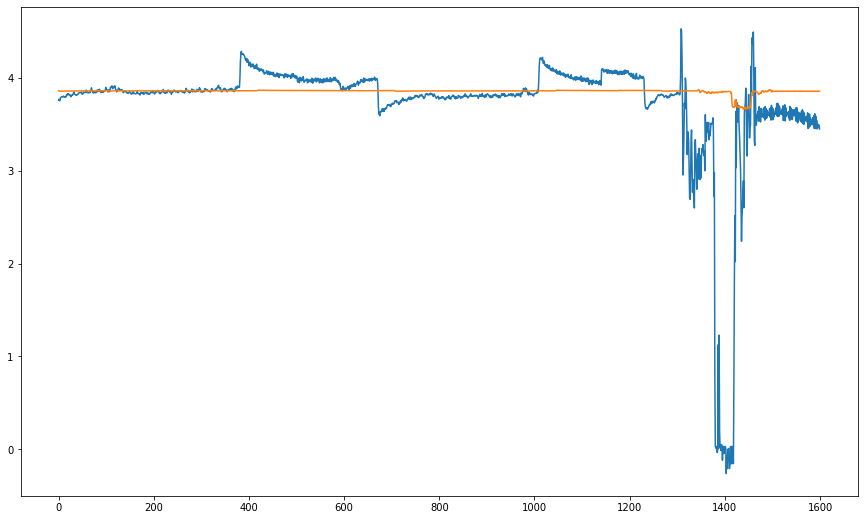

In [979]:
plt.figure(figsize=(15,9))

plt.plot(Test_X[:,0])
plt.plot(yhat[:,0])
